In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
dataset_path = '/content/drive/MyDrive/dataset for image classification'
os.chdir(dataset_path)

In [20]:
os.listdir(dataset_path)

['test', 'val', 'train']

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Increased rotation
    width_shift_range=0.4,      # Increased width shift
    height_shift_range=0.4,     # Increased height shift
    shear_range=0.3,            # Increased shear
    zoom_range=0.4,             # Increased zoom
    horizontal_flip=True,       # Enable horizontal flipping
    brightness_range=[0.7, 1.3],# Adjust lighting
    fill_mode='nearest',
    validation_split=0.2        # 80% training, 20% validation
)

# Validation data generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Validation data
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 241 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

{0: 2.2314814814814814, 1: 0.4781746031746032, 2: 2.171171171171171}


In [24]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Unfreeze the last 50 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 2,183,811 (8.33 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [25]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4115 - loss: 1.7943 - val_accuracy: 0.2188 - val_loss: 3.0097
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2812 - loss: 1.3871

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2812 - loss: 1.3871 - val_accuracy: 0.2500 - val_loss: 1.8325
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6046 - loss: 1.2516
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.4688 - loss: 1.0136 - val_accuracy: 0.3125 - val_loss: 1.7063
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3758 - loss: 1.0634 - val_accuracy: 0.6786 - val_loss: 1.4256
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5882 - loss: 1.1729  
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4624 - loss: 1.1817 - val_accuracy: 0.7188 - val_loss: 1.3170
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4062 - loss: 1.1217 - val_accuracy: 0.6071 - val_loss: 1.8297
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 972ms/step - accuracy: 0.5743 - loss: 0.9390
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - accuracy: 0.5938 - loss: 1.1226 - val_accuracy: 0.5312 - val_loss: 1.2879
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5588 - loss: 0.9419 - val_accuracy: 0.3571 - val_loss: 2.3460
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5312 - loss: 1.0269  
Epoch

In [26]:
# Unfreeze layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but the last 30 layers
    layer.trainable = False

# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Fine-tuning with more epochs
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights_dict,  # Add class weights here
    callbacks=[early_stopping]  # Add early stopping to prevent overfitting
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5117 - loss: 1.0596 - val_accuracy: 0.4375 - val_loss: 1.6776
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5938 - loss: 0.6512 - val_accuracy: 0.5714 - val_loss: 1.4202
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 983ms/step - accuracy: 0.5543 - loss: 0.9384
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.5294 - loss: 0.7500 - val_accuracy: 0.5000 - val_loss: 1.1876
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5380 - loss: 1.0096 - val_accuracy: 0.5357 - val_loss: 1.9386
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5625 - loss: 0.8982
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5311 - loss: 0.9399 - val_accuracy: 0.5000 - val_loss: 1.4936
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5625 - loss: 0.6470 - val_accuracy: 0.5000 - val_loss: 1.5871
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5388 - loss: 0.8785  

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation data again
val_preds = np.argmax(model.predict(validation_generator), axis=-1)
val_labels = validation_generator.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_labels, val_preds, target_names=list(validation_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
print(cm)

1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
              precision    recall  f1-score   support

        test       0.07      0.11      0.09         9
       train       0.65      0.57      0.61        42
         val       0.22      0.22      0.22         9

    accuracy                           0.45        60
   macro avg       0.31      0.30      0.31        60
weighted avg       0.50      0.45      0.47        60

[[ 1  7  1]
 [12 24  6]
 [ 1  6  2]]


In [28]:
model.save('/content/drive/MyDrive/Path/To/Save/Your/Model/model_name.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


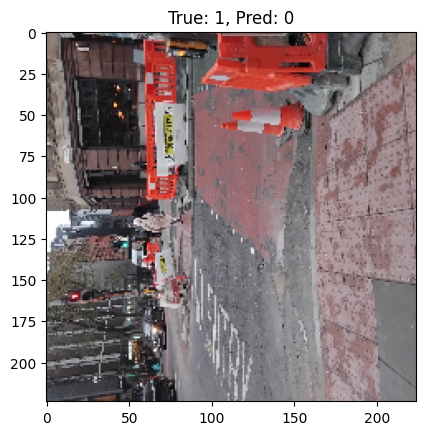

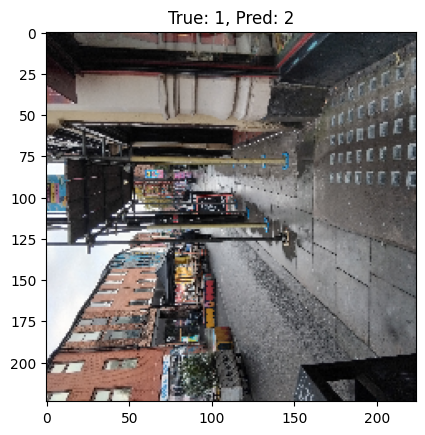

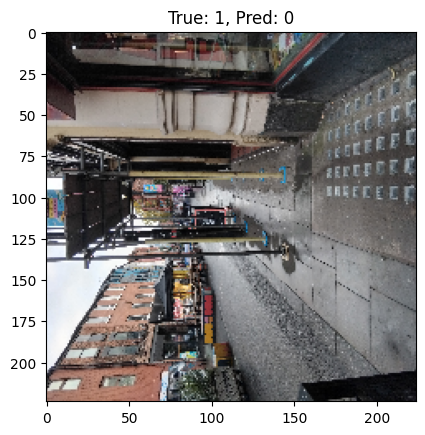

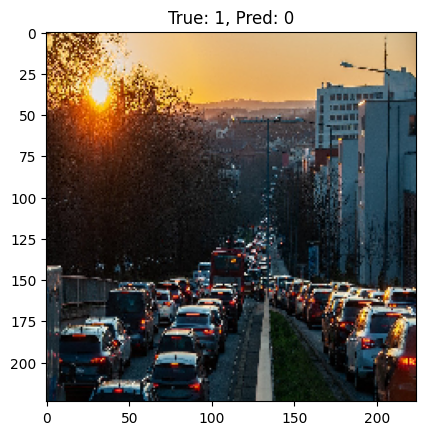

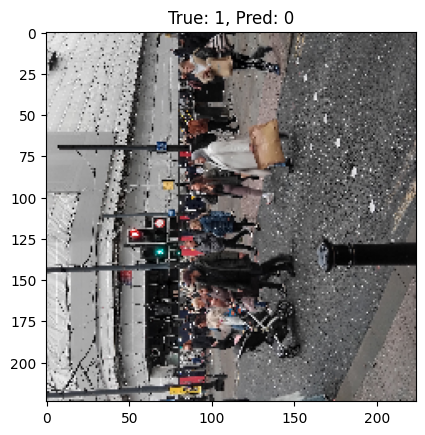

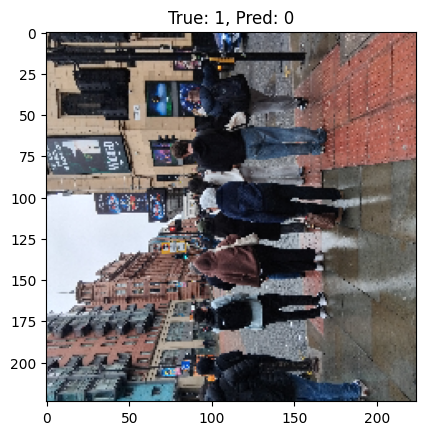

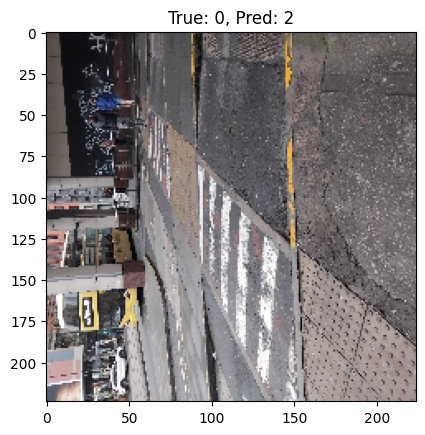

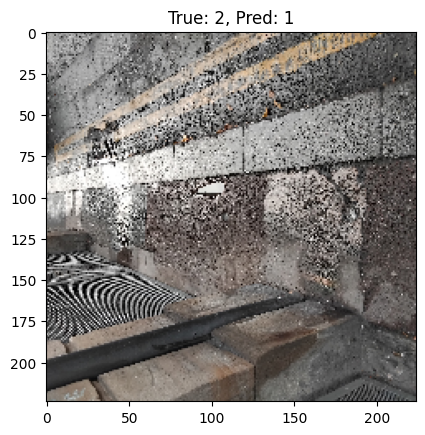

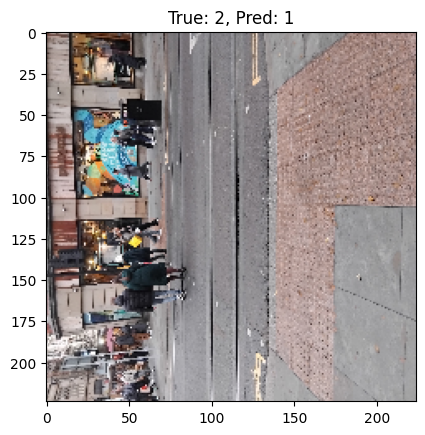

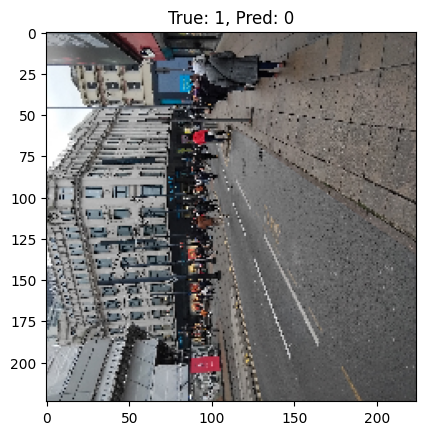

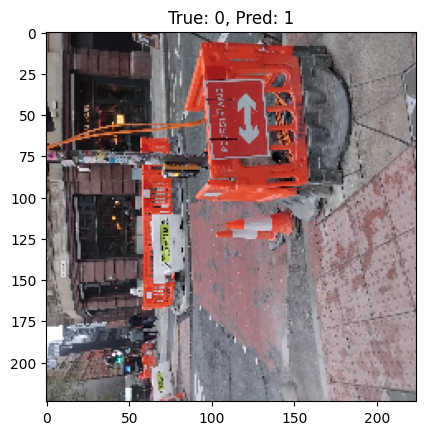

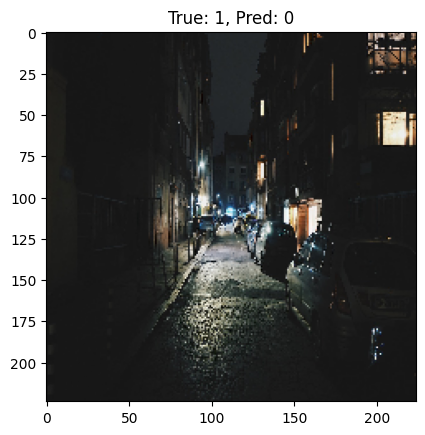

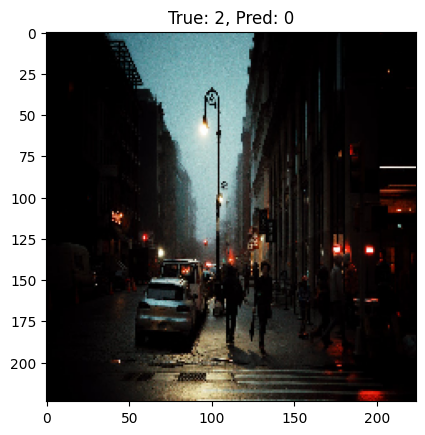

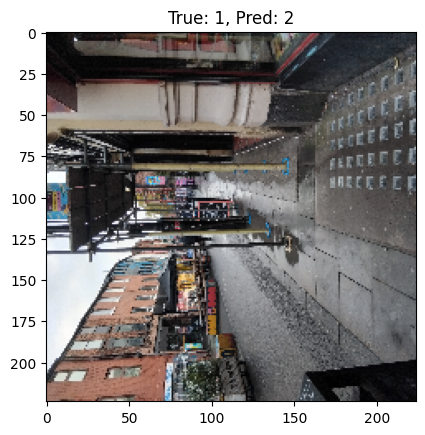

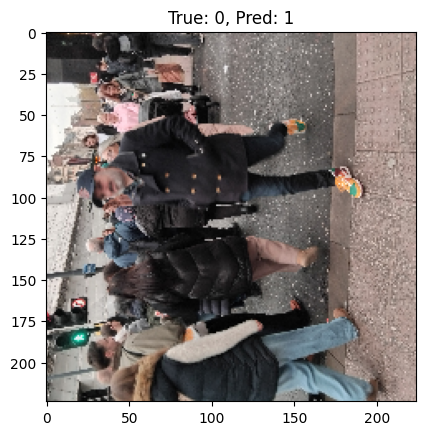

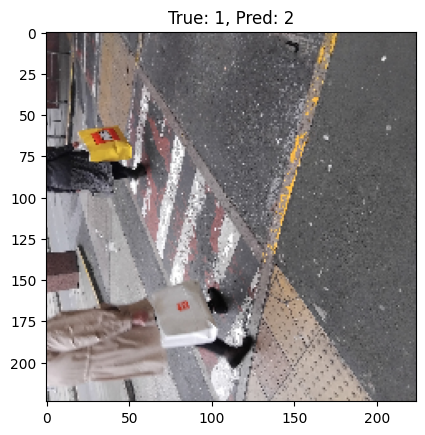

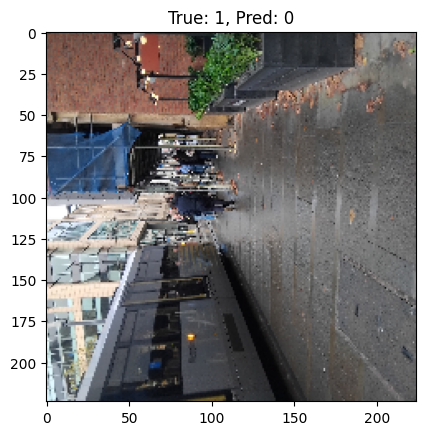

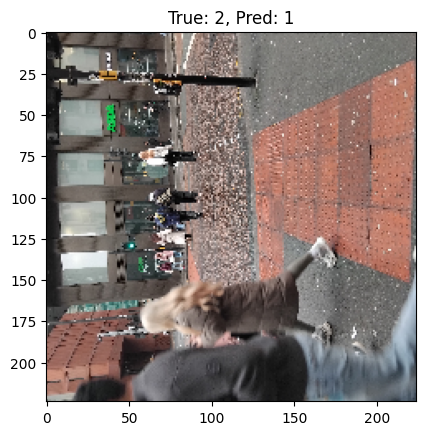

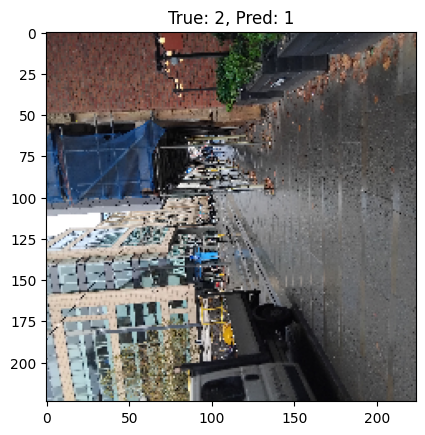

In [29]:
# Visualize misclassified images
val_images, val_labels = next(iter(validation_generator))
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

for i in range(len(val_images)):
    true_class = np.argmax(val_labels[i])
    if true_class != predicted_classes[i]:
        plt.imshow(val_images[i])
        plt.title(f"True: {true_class}, Pred: {predicted_classes[i]}")
        plt.show()

In [30]:
model.save('/content/drive/MyDrive/Path/To/Save/Your/Model/model_name.h5')